In [1]:
from autograd import *
from matplotlib import pyplot as plt
from keras.datasets import mnist
import numpy as np
import tensorflow as tf
import torch
from tqdm import tqdm_notebook
%matplotlib inline

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train /255
x_test = x_test / 255

x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

y_train = np.eye(10, dtype="i")[y_train]
y_test = np.eye(10, dtype="i")[y_test]

x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 10))

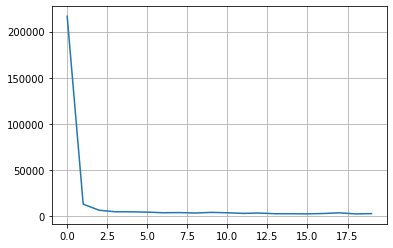

In [3]:
learning_rate = 0.02
n_steps = 20
story_loss = []
batch_size = 64
data_size = x_train.shape[0]
indexes = np.arange(60000)

with tf.name_scope("placeholders"):
    x = tf.placeholder(tf.float32, (None, 28, 28, 1), name='x')
    y = tf.placeholder(tf.float32, (None, 10), name='y')
with tf.name_scope('weights'):
    W1 = tf.Variable(tf.random_normal((5, 5, 1, 16), dtype=tf.float32), name='weights1')
    b1 = tf.Variable(tf.random_normal((1, 16), dtype=tf.float32), name='bias1')
    
    W2 = tf.Variable(tf.random_normal((24 * 24 * 16, 10), dtype=tf.float32), name="weights2")
    b2 = tf.Variable(tf.random_normal((1, 10), dtype=tf.float32), name="bias2")
with tf.name_scope('prediction'):
    y_pred = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') # same, valid
    y_pred = y_pred + b1
    y_pred = tf.nn.relu(y_pred)
    y_pred = tf.reshape(y_pred, (-1, 24 * 24 * 16))
    y_pred = y_pred @ W2 + b2
with tf.name_scope('loss'):
    l = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))
with tf.name_scope('optim'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(l)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(n_steps):
        step_loss = 0
        for _ in range(data_size // batch_size):
            batch_index = np.random.choice(indexes, batch_size)
            feed_dict = {x:x_train[batch_index], y:y_train[batch_index]}
            _, loss = sess.run([train_op, l], feed_dict=feed_dict)
            step_loss += loss
        story_loss.append(step_loss)
    weights1 = sess.run(W1)
    bias1 = sess.run(b1)
    weights2 = sess.run(W2)
    bias2 = sess.run(b2)
plt.plot(story_loss)
plt.grid()

Torch
===

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train /255
x_test = x_test / 255

x_train = x_train[:1000]
y_train = y_train[:1000]

x_train = x_train.reshape((-1, 1, 28, 28))
x_test = x_test.reshape((-1, 1, 28, 28))

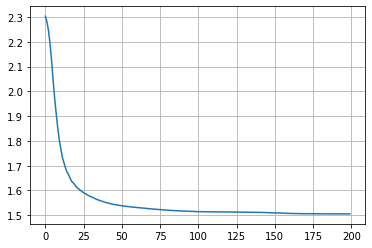

In [42]:
data = torch.Tensor(x_train)
target = torch.Tensor(y_train).long()

story_loss = []

con = torch.nn.Conv2d(1, 16, (8, 8))
tanh = torch.nn.Tanh()
con1 = torch.nn.Conv2d(16, 32, (3, 3))
relu = torch.nn.ReLU()
flat = torch.nn.Flatten()
fc = torch.nn.Linear(32 * 19 * 19, 10)
soft = torch.nn.Softmax(1)

model = torch.nn.Sequential(con, tanh, con1, relu, flat, fc, soft)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)

loss_func = torch.nn.CrossEntropyLoss()
for i in tqdm_notebook(range(200)):
    predict = model(data)
    loss = loss_func(predict, target)
    loss.backward()
    optimizer.step()
    story_loss.append(loss.item())
    
plt.plot(story_loss)
plt.grid()

In [43]:
test_data = torch.Tensor(x_test)

In [44]:
sum(model(test_data).data.numpy().argmax(1) == y_test)

8674

autograd
===

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:1000] / 255
y_train = y_train[:1000]

x_test = x_test / 255

x_train = x_train.reshape((*x_train.shape, 1))
x_test = x_test.reshape((*x_test.shape, 1))
x_train.shape, x_test.shape

((1000, 28, 28, 1), (10000, 28, 28, 1))

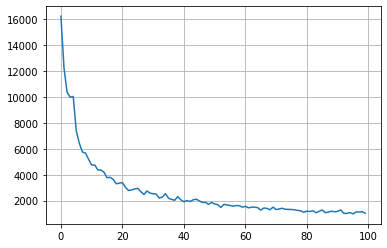

In [8]:
np.random.seed(1)
X = TensorData(x_train)
W1 = TensorData(np.random.laplace(scale=0.2, size=(5 * 5, 1, 16)))
W2 = TensorData(np.random.laplace(scale=0.2, size=(5 * 5, 16, 16)))
W3 = TensorData(np.random.laplace(scale=0.2, size=(1024, 10)))

test = X.in_conv(5, 5).dot(W1).out_conv().max_poling(2, 2).relu().in_conv(5, 5).dot(W2).tanh().flatten().drop_out().dot(W3).cross_entropy(y_train, 10)

all_loss = []
for i in tqdm_notebook(range(100)):
    all_loss.append(test.forward())
    test.bprop()
    W1.data -= W1.gradient * 0.0001
    W2.data -= W2.gradient * 0.0001
    W3.data -= W3.gradient * 0.0001
    W1.gradient *= 0.2
    W2.gradient *= 0.2
    W3.gradient *= 0.2

plt.plot(all_loss)
plt.grid()

In [9]:
XX = TensorData(x_test)
t = XX.in_conv(5, 5).dot(W1).out_conv().max_poling(2, 2).relu().in_conv(5, 5).dot(W2).tanh().flatten().dot(W3)
sum(t.forward().argmax(1) == y_test) / y_test.shape[0]

0.8709